## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import joblib
import os, sys
import shutil
%matplotlib inline 

lib_path = './../Sources/Utilities'
if (lib_path not in sys.path):
    sys.path.append(lib_path) #src directory

from messaging.print_functions import ProgressBar
from messaging.telegrambot import Bot
bot = Bot(user_credentials='./JFGS.json')

# Checking if bot is ok
bot.send_message(text="Hello, John")
progbar = ProgressBar(bar_length=20, bar_fill='#', elapsed_time=True)

## Getting Dataset

In [26]:
# dataset, dataset_type = 'MovieLens', '100k'
# dataset, dataset_type = 'BookCrossing', 'Standard'
# dataset, dataset_type = 'Amazon', 'MoviesTV'
dataset, dataset_type = 'Amazon', 'InstantVideo'
# dataset, dataset_type = 'Jester', 'jester'

folder = "../Datasets/" + dataset + "/" + dataset_type + "/"
filepath = "{}ratings.csv".format(folder)
output_folder = '../Datasets/' + dataset + '/' + dataset_type + '/outputs/'
dataset_output_folder = output_folder + 'sparsity_dataset/'

# Visualize file content
# df_whole = pd.read_csv(filepath, sep='\t', header=0, names=['user_id', 'item_id', 'rating', 'timestamp']) 
df_whole = pd.read_csv(filepath, sep='\t', header=0) 
df_whole.head()

,user_id,item_id,rating,timestamp
0,45550,0,5.0,1202256000
1,367442,0,5.0,1198195200
2,212056,1,4.0,1215388800
3,354802,1,4.0,1185840000
4,344843,1,2.0,1281052800


## Generating Dataset for each USS and ISS

In [33]:
df_whole.tail()

,user_id,item_id,rating,timestamp
583928,344395,23961,5.0,1405987200
583929,320050,23962,4.0,1405382400
583930,360238,23963,1.0,1405468800
583931,222722,23963,5.0,1405728000
583932,389399,23964,4.0,1405900800


In [34]:
df_users_uss = df_whole.groupby('user_id').count().reset_index()[['user_id', 'item_id']]
df_users_uss.columns = ['user_id', 'interactions']
df_users_uss['uss'] = 1 - df_users_uss['interactions'] / df_users_uss['interactions'].max()
df_users_uss.to_csv(output_folder + 'df_users_uss.tsv', sep = '\t', header = True, index = False)

In [35]:
df_items_iss = df_whole.groupby('item_id').count().reset_index()[['item_id', 'user_id']]
df_items_iss.columns = ['item_id', 'interactions']
df_items_iss['iss'] = 1 - df_items_iss['interactions'] / df_items_iss['interactions'].max()
df_items_iss.to_csv(output_folder + 'df_items_iss.tsv', sep = '\t', header = True, index = False)

In [36]:
uss_step = 0.01
iss_step = 0.01
uss_limits = np.arange(30, 101, uss_step*100)/100.0
iss_limits = np.arange(30, 101, iss_step*100)/100.0

In [45]:
if os.path.isdir(output_folder + 'sparsity_datasets'):    
    shutil.rmtree(output_folder + 'sparsity_datasets')
os.mkdir(output_folder + 'sparsity_datasets')    

In [46]:
%%time
counter = 0
df_overall_sparsity = pd.DataFrame(columns=['uss_limit', 'iss_limit', 'os', 'num_users', 'num_items'])

for uss_index, uss_limit in enumerate(uss_limits):
    progbar.update_progress(uss_index/float(len(uss_limits)-1))
    
    for iss_limit in iss_limits:

        users_ids = np.array(df_users_uss[df_users_uss['uss'] <= uss_limit]['user_id'])
        items_ids = np.array(df_items_iss[df_items_iss['iss'] <= iss_limit]['item_id'])

        df_filtered = df_whole[df_whole['user_id'].isin(users_ids)].reset_index(drop = True)
        df_filtered = df_filtered[df_filtered['item_id'].isin(items_ids)].reset_index(drop = True)

        overall_sparsity = 1-df_filtered.shape[0]/float(len(df_filtered['user_id'].unique())*len(df_filtered['item_id'].unique()))
        
        df_overall_sparsity.loc[counter] = [uss_limit, iss_limit, overall_sparsity, len(users_ids), len(items_ids)]
        
        filename = 'u.data'
        folder_name = 'sparsity_datasets/usslimit_' + str(uss_limit) + '_isslimit_' + str(iss_limit) + '/'
        path_filtered = output_folder + folder_name 

        
        if (df_filtered.shape[0] == 0):
            text = "ERROR: dataset with 0 rows"
            bot.send_message(text=text)        
            print (text)
            break
        elif (df_filtered.shape[0] == 1):
            df_filtered = pd.concat([df_filtered]*2, ignore_index=True)
        
        if not os.path.exists(path_filtered):
            os.makedirs(path_filtered)
            
        df_filtered.to_csv(path_filtered + filename, sep = '\t', header = False, index = False)
        
        counter += 1

text = "Finished creating sparsity datasets for {}/{} in {}".format(dataset, dataset_type, progbar.get_elapsed_time())
bot.send_message(text=text)        
df_overall_sparsity.to_csv(output_folder + 'df_overall_sparsity.tsv', sep = '\t', header = True, index = False)
df_overall_sparsity.head()

[0:02:09][####################] 100.00% Done...
Wall time: 3min 9s


## Generating USS and ISS analysis

In [32]:
df_overall_sparsity

,uss_limit,iss_limit,os,num_users,num_items
0,0.3,0.30,0.000000,3.0,3.0
1,0.3,0.31,0.000000,3.0,3.0
2,0.3,0.32,0.000000,3.0,4.0
3,0.3,0.33,0.000000,3.0,4.0
4,0.3,0.34,0.000000,3.0,4.0
5,0.3,0.35,0.000000,3.0,4.0
6,0.3,0.36,0.000000,3.0,4.0
7,0.3,0.37,0.000000,3.0,4.0
8,0.3,0.38,0.000000,3.0,4.0
9,0.3,0.39,0.000000,3.0,4.0


In [ ]:
df_overall_sparsity = pd.read_csv(output_folder + 'df_overall_sparsity.tsv', sep = '\t', header = 0)

[*] Saving 2d-num_items_x_isslimit.png figure to ../Datasets/Amazon/InstantVideo/outputs/Figures/ folder...
[+] Results saved.


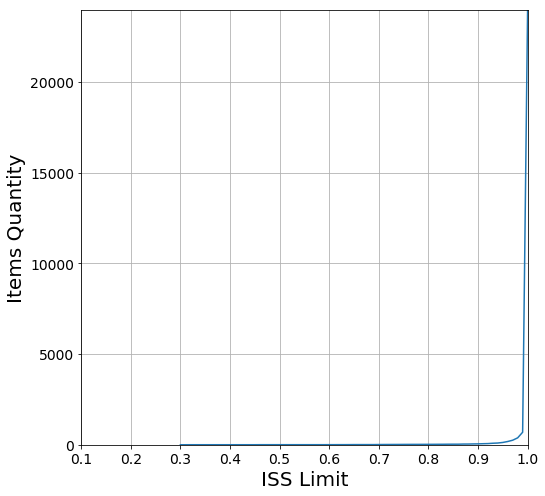

In [17]:
df_num_analysis = df_overall_sparsity.groupby(['iss_limit', 'num_items']).mean().reset_index()[['iss_limit', 'num_items', 'os']]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_num_analysis['iss_limit'], df_num_analysis['num_items'])
ax.axis([0.1, df_num_analysis['iss_limit'].max(), 0, df_num_analysis['num_items'].max()])
ax.grid(True)

ax.set_xticks([x/100.0 for x in np.arange (10, 110, 10)])
ax.set_xlabel('ISS Limit', fontsize = 20)
ax.set_ylabel('Items Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Saving figure
filename = '2d-num_items_x_isslimit.png';
fullpath = output_folder+'Figures/';
print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
fig.savefig(fullpath + filename, bbox_inches = 'tight')
print ("[+] Results saved.")

[*] Saving 2d-num_users_x_usslimit.png figure to ../Datasets/Amazon/InstantVideo/outputs/Figures/ folder...
[+] Results saved.


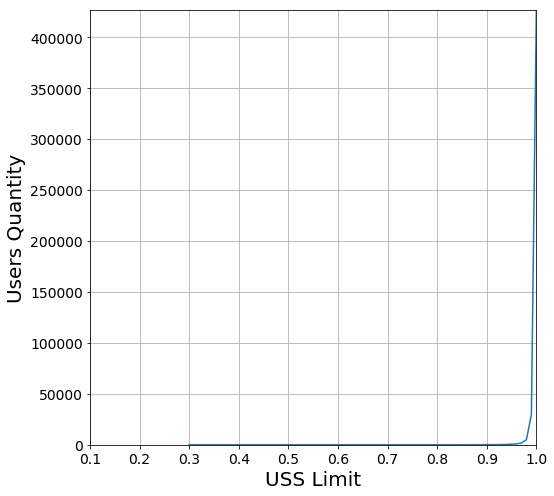

In [18]:
df_num_analysis = df_overall_sparsity.groupby(['uss_limit', 'num_users']).mean().reset_index()[['uss_limit', 'num_users', 'os']]

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(df_num_analysis['uss_limit'], df_num_analysis['num_users'])
ax.axis([0.1, df_num_analysis['uss_limit'].max(), 0, df_num_analysis['num_users'].max()])
ax.grid(True)

ax.set_xticks([x/100.0 for x in np.arange (10, 110, 10)])
ax.set_xlabel('USS Limit', fontsize = 20)
ax.set_ylabel('Users Quantity', fontsize = 20)
ax.tick_params(axis='both', which='major', labelsize=14)

# Saving figure
filename = '2d-num_users_x_usslimit.png';
fullpath = output_folder+'Figures/';
print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
fig.savefig(fullpath + filename, bbox_inches = 'tight')
print ("[+] Results saved.")

## Generating OS analysis

In [19]:
arr_os = np.zeros([len(uss_limits), len(iss_limits)])
for uss_index, uss_limit in enumerate(uss_limits):
    for iss_index, iss_limit in enumerate(iss_limits):
        arr_os[uss_index, iss_index] = df_overall_sparsity[(df_overall_sparsity['uss_limit'] == uss_limit) & (df_overall_sparsity['iss_limit'] == iss_limit)]['os'].reset_index(drop = True)[0]

joblib.dump(arr_os, output_folder + 'arr_os.joblib')        

['../Datasets/Amazon/InstantVideo/outputs/arr_os.joblib']

In [ ]:
arr_os = joblib.load(output_folder + 'arr_os.joblib')

In [30]:
10*tick_step

0

[*] Saving 2d-OS.png figure to ../Datasets/Amazon/InstantVideo/outputs/Figures/ folder...
[+] Results saved.


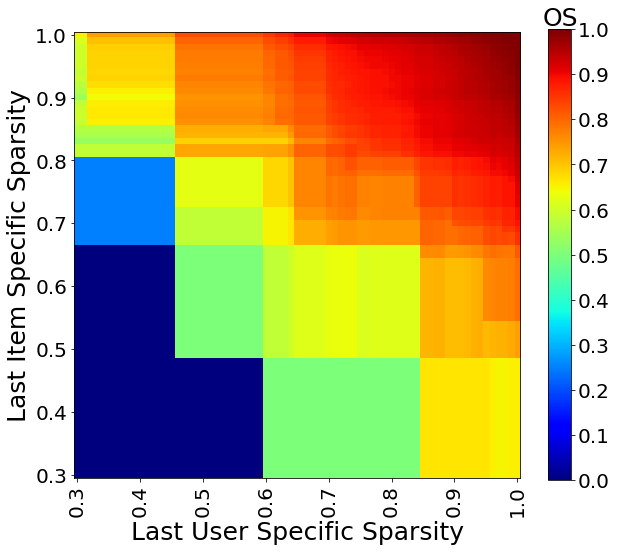

In [22]:
cmapping = "jet"
fig, ax = plt.subplots(figsize=(10,10))

# plt.subplot(1, 1, 1)
cax = plt.imshow(arr_os, cmap=cmapping)
plt.gca().invert_yaxis()
cbar = plt.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,10)], shrink = 0.83)
# plt.colorbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)

tick_step = int(10)

ax.set_xticklabels(uss_limits[0:len(uss_limits):tick_step])
ax.set_yticklabels(iss_limits[0:len(uss_limits):tick_step])

plt.xticks(np.arange(0, len(uss_limits), tick_step))
plt.yticks(np.arange(0, len(iss_limits), tick_step))

plt.clim(0, 1)


tick_fontsize = 20
label_fontsize = 25

# # Setting Labels
ax.set_xlabel('Last User Specific Sparsity', fontsize = label_fontsize)
ax.set_ylabel('Last Item Specific Sparsity', fontsize = label_fontsize)
# cbar = fig.colorbar(cax, ticks = [x/100.0 for x in np.arange(0,1000,5)])

plt.xticks(rotation = 'vertical')
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
cbar.set_label('OS', labelpad=-50,  y=1.05, rotation=0, fontsize = label_fontsize)
cbar.ax.tick_params(labelsize = tick_fontsize)


# Saving figure
filename = '2d-OS.png';
fullpath = output_folder+'Figures/';
print ("[*] Saving " + filename + " figure to " + fullpath + " folder...")
fig.savefig(fullpath + filename, bbox_inches = 'tight')
print ("[+] Results saved.")

In [23]:
bot.send_message(imgPath=fullpath + filename)

__________________